# Analisis de fuga de clientes - Model training

**Autor:** Roberto Muñoz <br />
**Github:** <https://github.com/rpmunoz> <br />

Este notebook muestra cómo entrenar un modelo supervisado para entender la fuga de clientes en la industria de Telecomunicaciones.

Este notebook se apoya en múltiples librerías estándar de python:

- numpy
- pandas
- matplotlib
- seaborn
- scikit-learn


Churn is a one of the biggest problem in  the telecom industry. Research has shown that the average monthly churn rate among the top 4 wireless carriers in the US is 1.9% - 2%. 

In [2]:
import os
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

sns.set(style = 'white')

## Cargamos los datos generados en el paso de data preparation

In [3]:
dataFile = 'data/Industria telco Kaggle - analisis de fuga - processed.csv'

df_dummies = pd.read_csv(dataFile)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


## Entrenar modelos de machine learning

Entrenaremos algunos modelos de Logistic Regression, Random Forest, SVM, ADA Boost and XG Boost

**1. Logistic Regression**

In [4]:
# We will use the data frame where we had created dummy variables
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])

# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

Es importante escalar las variables en la regresión logística para que todas estén dentro de un rango de 0 a 1. Esto me ayudó a mejorar la precisión del 79,7% al 80,7%.

Además, notará a continuación que la importancia de las variables también está alineada con lo que estamos viendo en el algoritmo Random Forest y la EDA que realizamos anteriormente.

In [5]:
# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [6]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
result = model.fit(X_train, y_train)

In [7]:
from sklearn import metrics
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print (metrics.accuracy_score(y_test, prediction_test))

0.8075829383886256


AxesSubplot(0.125,0.125;0.775x0.755)


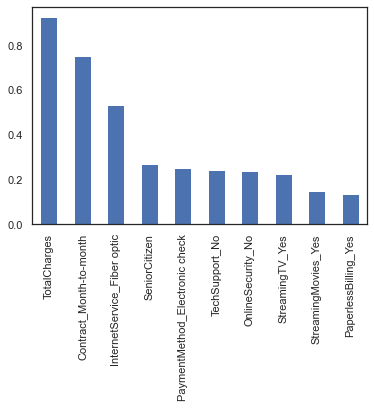

In [8]:
# To get the weights of all the variables
weights = pd.Series(model.coef_[0],
                 index=X.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))


AxesSubplot(0.125,0.125;0.775x0.755)


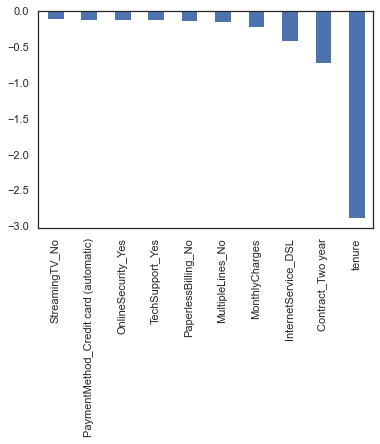

In [9]:
print(weights.sort_values(ascending = False)[-10:].plot(kind='bar'))

**Notas**

Podemos ver que algunas variables tienen una relación negativa con nuestra variable predicha (Churn), mientras que otras tienen una relación positiva. La relación negativa significa que la probabilidad de abandono disminuye con esa variable. Resumamos algunas de las características interesantes a continuación:

* Como vimos en nuestra EDA, tener un contrato de 2 meses reduce las posibilidades de abandono. El contrato de 2 meses junto con la tenencia tienen la relación más negativa con el Churn según lo predicho por las regresiones logísticas
* Tener servicio de Internet DSL también reduce la probabilidad de abandono
* Por último, los cargos totales, los contratos mensuales, los servicios de Internet de fibra óptica y la antigüedad pueden generar tasas de abandono más altas. Esto es interesante porque aunque los servicios de fibra óptica son más rápidos, es probable que los clientes abandonen debido a ello. Creo que necesitamos explorar más para comprender mejor por qué está sucediendo esto.

¡Cualquier hipótesis sobre lo anterior sería realmente útil!

**2. Random Forest**

In [10]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

0.8088130774697939


<AxesSubplot:>

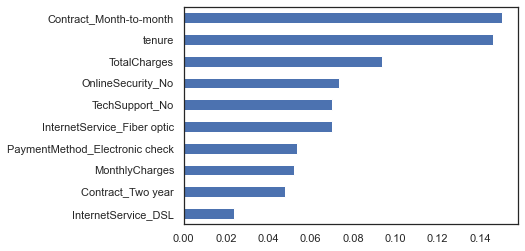

In [11]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

**Notas:**

* A partir del algoritmo de bosque aleatorio, el contrato mensual, la tenencia y los cargos totales son las variables predictoras más importantes para predecir la deserción.
* Los resultados del bosque aleatorio son muy similares a los de la regresión logística y están en línea con lo que esperábamos de nuestra EDA

**3. Support Vecor Machine (SVM)**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [13]:
from sklearn.svm import SVC

model.svm = SVC(kernel='linear') 
model.svm.fit(X_train,y_train)
preds = model.svm.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.820184790334044

In [14]:
# Create the Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,preds))  

[[953  89]
 [164 201]]


Con SVM pude aumentar la precisión hasta un 82%. Sin embargo, debemos analizar más a fondo las tasas verdaderas positivas y negativas verdaderas, incluido el área bajo la curva (AUC) para una mejor predicción. Exploraré esto pronto. ¡Manténganse al tanto!

In [15]:
dataFile = 'data/Industria telco Kaggle - analisis de fuga.csv'

telecom_cust = pd.read_csv(dataFile)

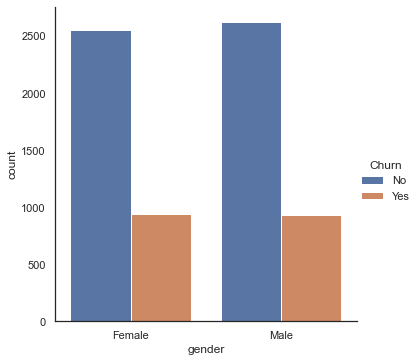

In [16]:
ax1 = sns.catplot(x="gender", kind="count", hue="Churn", data=telecom_cust,
                  estimator=lambda x: sum(x==0)*100.0/len(x))
#ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

**4. ADA Boost**

In [17]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
# n_estimators = 50 (default value) 
# base_estimator = DecisionTreeClassifier (default value)
model.fit(X_train,y_train)
preds = model.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.8159203980099502

**5. XG Boost**

In [18]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.8095238095238095

Curiosamente, con XG Boost pude aumentar la precisión de los datos de prueba a casi un 83%. Claramente, XG Boost es un ganador entre todas las demás técnicas. XG Boost es un modelo de aprendizaje lento y se basa en el concepto de Boosting